In [ ]:
import os
from glob import glob
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
from roboflow import Roboflow
from dotenv import load_dotenv
from ultralytics import YOLO
import random

In [2]:
load_dotenv()
api_key = os.getenv('ROBOFLOW_KEY')
dataset_version = 17
rf = Roboflow(api_key)
project = rf.workspace("receipt-dataset-awcrq").project("renote-polygon")
version = project.version(dataset_version)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ReNote-Polygon-17 in yolov11:: 100%|██████████| 2358/2358 [00:01<00:00, 1933.17it/s]


In [3]:
ROOT_DIR = os.getcwd()
DATASET_DIR = os.path.join(ROOT_DIR, f"ReNote-Polygon-{dataset_version}")
MODEL_DIR = os.path.join(ROOT_DIR, "runs", "train")
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, "train", "images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train", "labels")
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, "valid", "images")
VALID_LABEL_DIR = os.path.join(DATASET_DIR, "valid", "labels")
ANNOTATION_PATH = os.path.join(DATASET_DIR, "data.yaml")

In [ ]:
model = YOLO("yolo11x-seg.pt")

#Turn this on for GPU & CUDA support
#model.to('cuda')

# Train the model
results = model.train(data=ANNOTATION_PATH,
                      epochs=100,
                      imgsz=640,
                      batch=8,
                      name="model_train_renfred_1",
                      project="runs/train",
                    #   lr0=0.0001,
                    #   lrf=0.05,
                      workers=8
                      )

In [ ]:
best_model = "model_train_renfred_1"
weight_path = "weights/best.pt"

model_path = os.path.join(MODEL_DIR, best_model, weight_path)
model = YOLO(model_path, task='segment')

image_files = [f for f in os.listdir(VALID_IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)
test_image_path = os.path.join(VALID_IMAGE_DIR, random_image)

# Run the model on the random image
results = model(test_image_path, conf=0.3)
results[0].show()

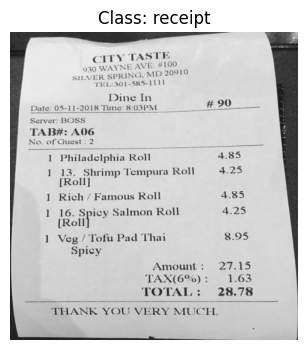

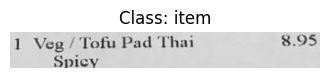

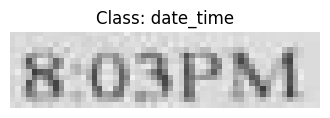

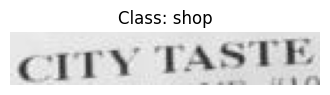

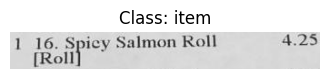

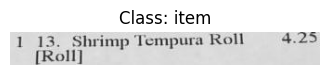

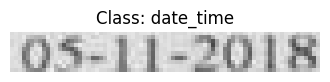

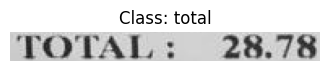

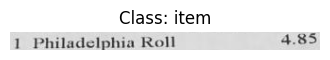

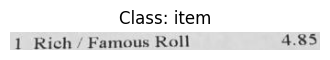

In [5]:
result = results[0]
boxes = result.boxes
class_names = result.names

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    class_id = int(box.cls[0])
    class_name = class_names.get(class_id, "unknown")

    cropped_img = result.orig_img[y1:y2, x1:x2]

    plt.figure(figsize=(4, 4))
    plt.imshow(cropped_img)
    plt.title(f"Class: {class_name}")
    plt.axis("off")
    plt.show()